# Лабораторная работа №4: Исследование случайного леса

## Часть 1: Случайный лес для классификации (сухие бобы)

### Описание задачи
Использование случайного леса для классификации видов сухих бобов. Случайный лес - это ансамбль
решающих деревьев, где каждое дерево обучается на случайной подвыборке данных и признаков.

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

## 1. Загрузка и подготовка данных

In [4]:
df_beans = pd.read_csv('/content/drive/MyDrive/datasets/Dry_Bean_Dataset.csv')

X_beans = df_beans.drop('Class', axis=1)
y_beans = df_beans['Class']

X_train_beans, X_test_beans, y_train_beans, y_test_beans = train_test_split(
    X_beans, y_beans, test_size=0.2, random_state=42, stratify=y_beans
)

print(f'Обучающая выборка: {X_train_beans.shape}')
print(f'Тестовая выборка: {X_test_beans.shape}')

Обучающая выборка: (10888, 16)
Тестовая выборка: (2723, 16)


## 2. Бейзлайн: случайный лес с параметрами по умолчанию

In [5]:
rf_baseline = RandomForestClassifier(random_state=42)
rf_baseline.fit(X_train_beans, y_train_beans)

y_pred_baseline = rf_baseline.predict(X_test_beans)
acc_baseline = accuracy_score(y_test_beans, y_pred_baseline)

print(f'Baseline Accuracy: {acc_baseline:.4f}')
print(f'Количество деревьев: {rf_baseline.n_estimators}')
print(f'\nОтчёт по метрикам:')
print(classification_report(y_test_beans, y_pred_baseline))

Baseline Accuracy: 0.9203
Количество деревьев: 100

Отчёт по метрикам:
              precision    recall  f1-score   support

    BARBUNYA       0.94      0.89      0.92       265
      BOMBAY       1.00      1.00      1.00       104
        CALI       0.94      0.94      0.94       326
    DERMASON       0.90      0.92      0.91       709
       HOROZ       0.97      0.95      0.96       386
       SEKER       0.94      0.96      0.95       406
        SIRA       0.86      0.86      0.86       527

    accuracy                           0.92      2723
   macro avg       0.93      0.93      0.93      2723
weighted avg       0.92      0.92      0.92      2723



## 3. Улучшение бейзлайна

### Гипотеза 1: Количество деревьев в лесу

Больше деревьев обычно ведёт к лучшему качеству, но с убывающей отдачей.

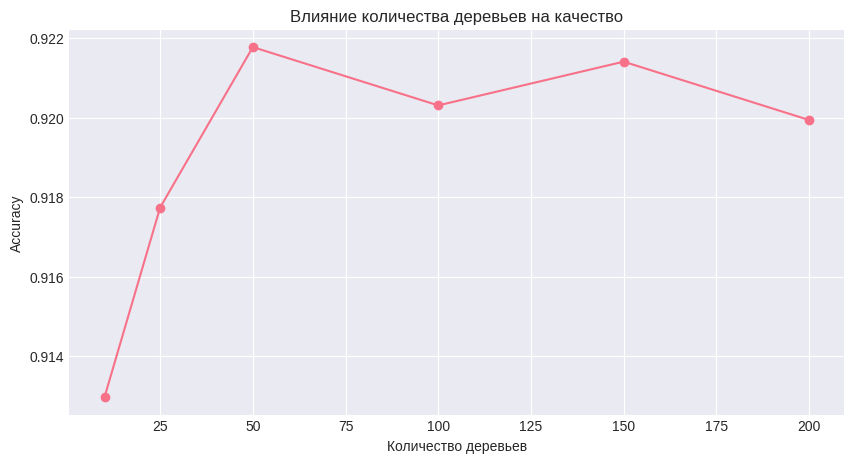

Оптимальное количество деревьев: 50


In [5]:
n_estimators_list = [10, 25, 50, 100, 150, 200]
test_scores = []

for n_est in n_estimators_list:
    rf = RandomForestClassifier(n_estimators=n_est, random_state=42)
    rf.fit(X_train_beans, y_train_beans)
    score = rf.score(X_test_beans, y_test_beans)
    test_scores.append(score)

plt.figure(figsize=(10, 5))
plt.plot(n_estimators_list, test_scores, marker='o')
plt.xlabel('Количество деревьев')
plt.ylabel('Accuracy')
plt.title('Влияние количества деревьев на качество')
plt.grid(True)
plt.show()

best_n_estimators = n_estimators_list[np.argmax(test_scores)]
print(f'Оптимальное количество деревьев: {best_n_estimators}')

### Гипотеза 2: Максимальная глубина деревьев

In [6]:
max_depths = [5, 10, 15, 20, None]
depth_scores = []

for depth in max_depths:
    rf = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=depth, random_state=42)
    rf.fit(X_train_beans, y_train_beans)
    score = rf.score(X_test_beans, y_test_beans)
    depth_scores.append(score)
    depth_label = str(depth) if depth is not None else 'None'
    print(f'max_depth={depth_label}: {score:.4f}')

best_max_depth = max_depths[np.argmax(depth_scores)]
print(f'\nОптимальная глубина: {best_max_depth}')

max_depth=5: 0.8851
max_depth=10: 0.9185
max_depth=15: 0.9218
max_depth=20: 0.9210
max_depth=None: 0.9218

Оптимальная глубина: 15


### Гипотеза 3: Минимальное число образцов в листе

In [7]:
min_samples_list = [1, 2, 5, 10]
leaf_scores = []

for min_leaf in min_samples_list:
    rf = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth,
                                min_samples_leaf=min_leaf, random_state=42)
    rf.fit(X_train_beans, y_train_beans)
    score = rf.score(X_test_beans, y_test_beans)
    leaf_scores.append(score)
    print(f'min_samples_leaf={min_leaf}: {score:.4f}')

best_min_leaf = min_samples_list[np.argmax(leaf_scores)]
print(f'\nОптимальный min_samples_leaf: {best_min_leaf}')

min_samples_leaf=1: 0.9218
min_samples_leaf=2: 0.9188
min_samples_leaf=5: 0.9203
min_samples_leaf=10: 0.9159

Оптимальный min_samples_leaf: 1


### Улучшенная модель случайного леса

In [8]:
rf_improved = RandomForestClassifier(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_leaf=best_min_leaf,
    random_state=42
)
rf_improved.fit(X_train_beans, y_train_beans)

y_pred_improved = rf_improved.predict(X_test_beans)
acc_improved = accuracy_score(y_test_beans, y_pred_improved)

print(f'Улучшенная модель Accuracy: {acc_improved:.4f}')
print(f'Улучшение: {(acc_improved - acc_baseline) * 100:.2f}%')
print(f'\nОтчёт по метрикам:')
print(classification_report(y_test_beans, y_pred_improved))

Улучшенная модель Accuracy: 0.9218
Улучшение: 0.15%

Отчёт по метрикам:
              precision    recall  f1-score   support

    BARBUNYA       0.94      0.89      0.92       265
      BOMBAY       1.00      1.00      1.00       104
        CALI       0.94      0.94      0.94       326
    DERMASON       0.91      0.92      0.92       709
       HOROZ       0.97      0.96      0.96       386
       SEKER       0.94      0.96      0.95       406
        SIRA       0.86      0.86      0.86       527

    accuracy                           0.92      2723
   macro avg       0.94      0.93      0.93      2723
weighted avg       0.92      0.92      0.92      2723



### Важность признаков

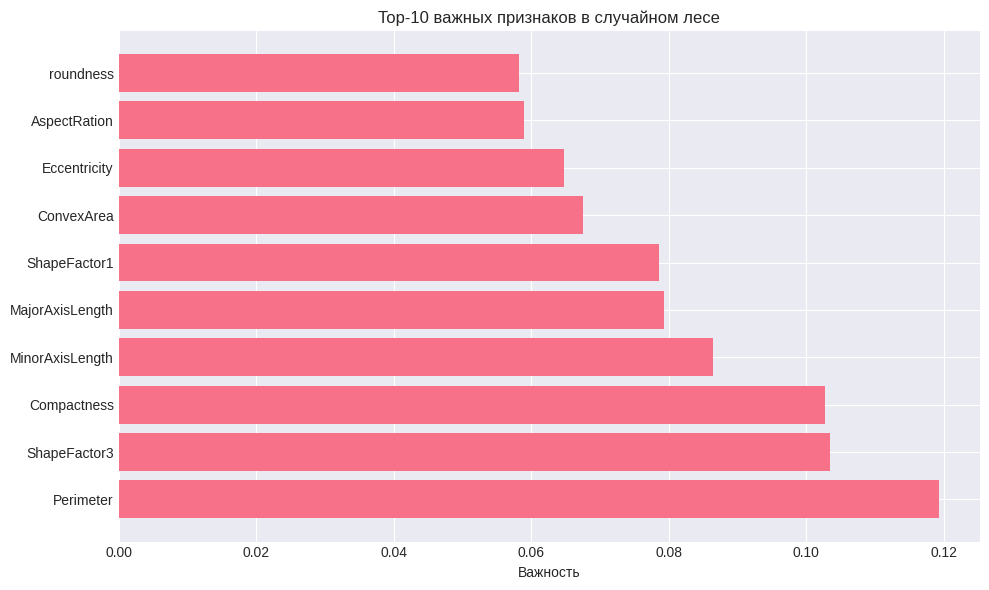


Топ-5 признаков:
            Feature  Importance
1         Perimeter    0.119283
14     ShapeFactor3    0.103385
11      Compactness    0.102761
3   MinorAxisLength    0.086457
2   MajorAxisLength    0.079254


In [9]:
feature_importance = pd.DataFrame({
    'Feature': X_beans.columns,
    'Importance': rf_improved.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'][:10], feature_importance['Importance'][:10])
plt.xlabel('Важность')
plt.title('Top-10 важных признаков в случайном лесе')
plt.tight_layout()
plt.show()

print('\nТоп-5 признаков:')
print(feature_importance.head())

### Матрица ошибок

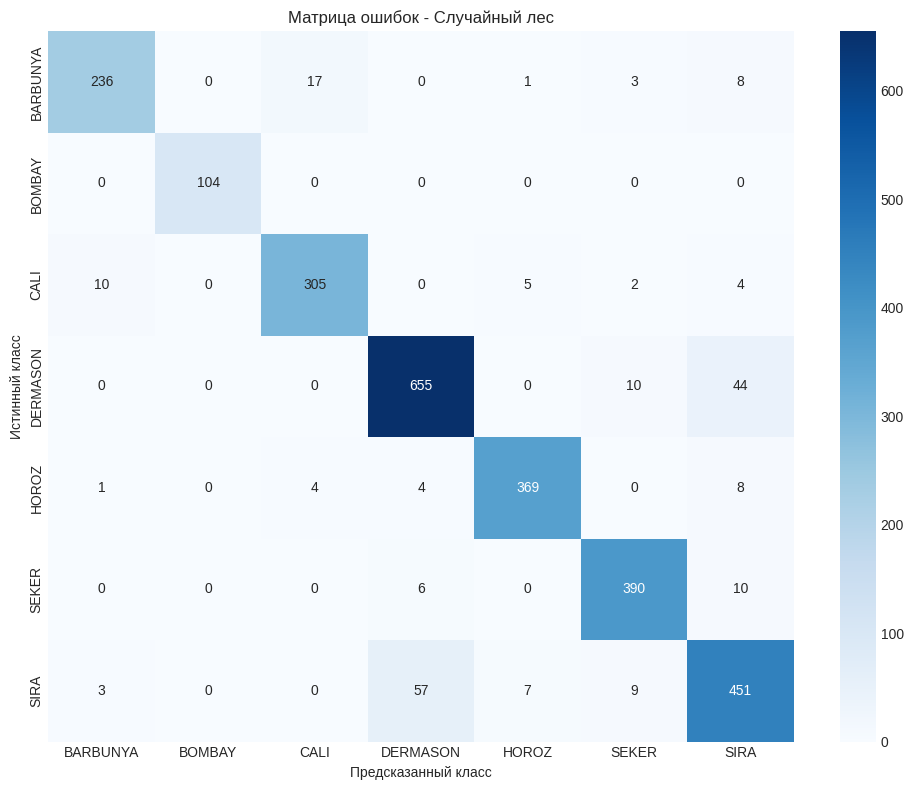

In [10]:
cm = confusion_matrix(y_test_beans, y_pred_improved)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=rf_improved.classes_,
            yticklabels=rf_improved.classes_)
plt.title('Матрица ошибок - Случайный лес')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.tight_layout()
plt.show()

## 4. Собственная реализация случайного леса

In [13]:
class CustomDecisionTree:
    def __init__(self, max_depth=None, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.tree = None
        self.classes_ = None

    def _gini(self, y):
        _, counts = np.unique(y, return_counts=True)
        impurity = 1.0 - sum((count / len(y)) ** 2 for count in counts)
        return impurity

    def _build_tree(self, X, y, depth=0, feature_indices=None):
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))

        if feature_indices is None:
            feature_indices = np.arange(n_features)

        if (self.max_depth is not None and depth >= self.max_depth) or \
           n_samples < 2 * self.min_samples_leaf or n_classes == 1:
            leaf_value = pd.Series(y).value_counts().idxmax()
            return {'is_leaf': True, 'value': leaf_value}

        best_gini = float('inf')
        best_feature = None
        best_threshold = None

        for feature in feature_indices:
            unique_values = np.unique(X[:, feature])
            if len(unique_values) > 10:
                 thresholds = np.percentile(unique_values, np.linspace(10, 90, 9))
            else:
                 thresholds = unique_values

            for threshold in thresholds:
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask
                y_l, y_r = y[left_mask], y[right_mask]

                if len(y_l) < self.min_samples_leaf or len(y_r) < self.min_samples_leaf:
                    continue

                gini = (len(y_l) * self._gini(y_l) + len(y_r) * self._gini(y_r)) / n_samples
                if gini < best_gini:
                    best_gini = gini
                    best_feature = feature
                    best_threshold = threshold

        if best_feature is None:
            leaf_value = pd.Series(y).value_counts().idxmax()
            return {'is_leaf': True, 'value': leaf_value}

        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask

        return {
            'is_leaf': False,
            'feature': best_feature,
            'threshold': best_threshold,
            'left': self._build_tree(X[left_mask], y[left_mask], depth + 1, feature_indices),
            'right': self._build_tree(X[right_mask], y[right_mask], depth + 1, feature_indices)
        }

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.tree = self._build_tree(X.values if isinstance(X, pd.DataFrame) else X,
                                     y.values if isinstance(y, pd.Series) else y)
        return self

    def _predict_sample(self, x, node):
        if node['is_leaf']:
            return node['value']
        if x[node['feature']] <= node['threshold']:
            return self._predict_sample(x, node['left'])
        return self._predict_sample(x, node['right'])

    def predict(self, X):
        X_array = X.values if isinstance(X, pd.DataFrame) else X
        return np.array([self._predict_sample(x, self.tree) for x in X_array])

    def score(self, X, y):
        y_array = y.values if isinstance(y, pd.Series) else y
        predictions = self.predict(X)
        return np.mean(predictions == y_array)


class CustomRandomForestClassifier:
    def __init__(self, n_estimators=100, max_depth=None, min_samples_leaf=1, random_state=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.random_state = random_state
        self.trees = []
        self.classes_ = None

    def _bootstrap_sample(self, X, y):
        n = X.shape[0]
        indices = np.random.choice(n, n, replace=True)
        return X[indices], y[indices]

    def fit(self, X, y):
        if self.random_state is not None:
            np.random.seed(self.random_state)

        self.classes_ = np.unique(y)
        X_array = X.values if isinstance(X, pd.DataFrame) else X
        y_array = y.values if isinstance(y, pd.Series) else y

        for _ in range(self.n_estimators):
            X_boot, y_boot = self._bootstrap_sample(X_array, y_array)
            tree = CustomDecisionTree(max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf)
            tree.fit(X_boot, y_boot)
            self.trees.append(tree)

        return self

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])

        final_predictions = []
        for i in range(predictions.shape[1]):
            sample_preds = predictions[:, i]
            vals, counts = np.unique(sample_preds, return_counts=True)
            most_common = vals[np.argmax(counts)]
            final_predictions.append(most_common)

        return np.array(final_predictions)

    def score(self, X, y):
        y_array = y.values if isinstance(y, pd.Series) else y
        predictions = self.predict(X)
        return np.mean(predictions == y_array)


In [14]:
rf_custom = CustomRandomForestClassifier(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_leaf=best_min_leaf,
    random_state=42
)
rf_custom.fit(X_train_beans, y_train_beans)

y_pred_custom = rf_custom.predict(X_test_beans)
acc_custom = accuracy_score(y_test_beans, y_pred_custom)

print(f'Собственная реализация Accuracy: {acc_custom:.4f}')
print(f'sklearn Accuracy: {acc_improved:.4f}')
print(f'Разница: {abs(acc_custom - acc_improved):.6f}')

Собственная реализация Accuracy: 0.9214
sklearn Accuracy: 0.9218
Разница: 0.000367


### Сравнение результатов классификации


Сравнение моделей классификации:
                Модель  Accuracy
              Baseline  0.920308
     Улучшенная (n=50)  0.921777
Собственная реализация  0.921410


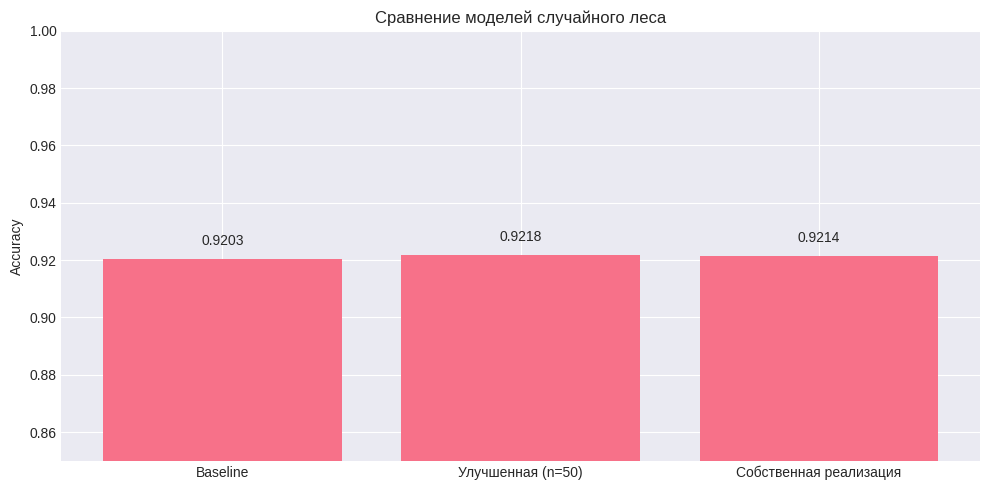

In [15]:
comparison_class = pd.DataFrame({
    'Модель': ['Baseline', f'Улучшенная (n={best_n_estimators})', 'Собственная реализация'],
    'Accuracy': [acc_baseline, acc_improved, acc_custom]
})
print('\nСравнение моделей классификации:')
print(comparison_class.to_string(index=False))

plt.figure(figsize=(10, 5))
plt.bar(comparison_class['Модель'], comparison_class['Accuracy'])
plt.ylabel('Accuracy')
plt.title('Сравнение моделей случайного леса')
plt.ylim([0.85, 1.0])
for i, v in enumerate(comparison_class['Accuracy']):
    plt.text(i, v + 0.005, f'{v:.4f}', ha='center')
plt.tight_layout()
plt.show()

### Выводы по классификации со случайным лесом

1. Случайный лес обычно показывает лучшие результаты благодаря ансамблевому подходу.
2. Количество деревьев, их глубина и min_samples_leaf - ключевые гиперпараметры.
3. Важность признаков в лесе более надёжна, чем в одном дереве.
4. Собственная реализация подтверждает основной принцип работы: Bootstrap + Aggregating.

---

## Часть 2: Случайный лес для регрессии (предсказание рейтинга вин)

In [9]:
df_wines = pd.read_csv('/content/drive/MyDrive/datasets/winemag-data-130k-v2.csv')


df_wines_sample = df_wines[['price', 'points']].sample(20000, random_state=42)
df_wines_clean = df_wines_sample.dropna()

X_wines = df_wines_clean.drop('points', axis=1)
y_wines = df_wines_clean['points']

X_train_wines, X_test_wines, y_train_wines, y_test_wines = train_test_split(
    X_wines, y_wines, test_size=0.2, random_state=42
)

print(f'Обучающая выборка: {X_train_wines.shape}')
print(f'Тестовая выборка: {X_test_wines.shape}')

Обучающая выборка: (14883, 1)
Тестовая выборка: (3721, 1)


## 2. Бейзлайн и улучшение

In [10]:
rf_reg_baseline = RandomForestRegressor(random_state=42)
rf_reg_baseline.fit(X_train_wines, y_train_wines)

y_pred_reg_baseline = rf_reg_baseline.predict(X_test_wines)

mae_baseline = mean_absolute_error(y_test_wines, y_pred_reg_baseline)
rmse_baseline = np.sqrt(mean_squared_error(y_test_wines, y_pred_reg_baseline))
r2_baseline = r2_score(y_test_wines, y_pred_reg_baseline)

print('Baseline регрессия:')
print(f'MAE: {mae_baseline:.4f}')
print(f'RMSE: {rmse_baseline:.4f}')
print(f'R²: {r2_baseline:.4f}')

Baseline регрессия:
MAE: 1.8783
RMSE: 2.3952
R²: 0.3910


### Подбор параметров для регрессии

In [11]:
n_est_reg = 100
max_depth_reg = 10

rf_reg_improved = RandomForestRegressor(
    n_estimators=n_est_reg,
    max_depth=max_depth_reg,
    min_samples_leaf=5,
    random_state=42
)
rf_reg_improved.fit(X_train_wines, y_train_wines)

y_pred_reg_improved = rf_reg_improved.predict(X_test_wines)

mae_improved = mean_absolute_error(y_test_wines, y_pred_reg_improved)
rmse_improved = np.sqrt(mean_squared_error(y_test_wines, y_pred_reg_improved))
r2_improved = r2_score(y_test_wines, y_pred_reg_improved)

print('Улучшенная модель регрессии:')
print(f'MAE: {mae_improved:.4f}')
print(f'RMSE: {rmse_improved:.4f}')
print(f'R²: {r2_improved:.4f}')
print(f'Улучшение R²: {(r2_improved - r2_baseline) * 100:.2f}%')

Улучшенная модель регрессии:
MAE: 1.8724
RMSE: 2.3861
R²: 0.3956
Улучшение R²: 0.46%


### Собственная реализация для регрессии

In [12]:
class CustomDecisionTreeRegressor:
    def __init__(self, max_depth=None, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.tree = None

    def _mse(self, y):
        if len(y) == 0:
            return 0
        return np.mean((y - np.mean(y)) ** 2)

    def _build_tree(self, X, y, depth=0):
        n_samples = X.shape[0]

        if (self.max_depth is not None and depth >= self.max_depth) or \
           n_samples < 2 * self.min_samples_leaf:
            return {'is_leaf': True, 'value': np.mean(y)}

        best_mse = float('inf')
        best_feature = None
        best_threshold = None

        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask
                y_l, y_r = y[left_mask], y[right_mask]

                if len(y_l) < self.min_samples_leaf or len(y_r) < self.min_samples_leaf:
                    continue

                mse = (len(y_l) * self._mse(y_l) + len(y_r) * self._mse(y_r)) / n_samples
                if mse < best_mse:
                    best_mse = mse
                    best_feature = feature
                    best_threshold = threshold

        if best_feature is None:
            return {'is_leaf': True, 'value': np.mean(y)}

        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask

        return {
            'is_leaf': False,
            'feature': best_feature,
            'threshold': best_threshold,
            'left': self._build_tree(X[left_mask], y[left_mask], depth + 1),
            'right': self._build_tree(X[right_mask], y[right_mask], depth + 1)
        }

    def fit(self, X, y):
        X_array = X.values if isinstance(X, pd.DataFrame) else X
        y_array = y.values if isinstance(y, pd.Series) else y
        self.tree = self._build_tree(X_array, y_array)
        return self

    def _predict_sample(self, x, node):
        if node['is_leaf']:
            return node['value']
        if x[node['feature']] <= node['threshold']:
            return self._predict_sample(x, node['left'])
        return self._predict_sample(x, node['right'])

    def predict(self, X):
        X_array = X.values if isinstance(X, pd.DataFrame) else X
        return np.array([self._predict_sample(x, self.tree) for x in X_array])

    def score(self, X, y):
        y_array = y.values if isinstance(y, pd.Series) else y
        predictions = self.predict(X)
        return r2_score(y_array, predictions)

class CustomRandomForestRegressor:
    def __init__(self, n_estimators=100, max_depth=None, min_samples_leaf=1, random_state=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.random_state = random_state
        self.trees = []

    def _bootstrap_sample(self, X, y):
        n = X.shape[0]
        indices = np.random.choice(n, n, replace=True)
        return X[indices], y[indices]

    def fit(self, X, y):
        if self.random_state is not None:
            np.random.seed(self.random_state)

        X_array = X.values if isinstance(X, pd.DataFrame) else X
        y_array = y.values if isinstance(y, pd.Series) else y

        for _ in range(self.n_estimators):
            X_boot, y_boot = self._bootstrap_sample(X_array, y_array)
            tree = CustomDecisionTreeRegressor(max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf)
            tree.fit(X_boot, y_boot)
            self.trees.append(tree)

        return self

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        return np.mean(predictions, axis=0)

    def score(self, X, y):
        y_array = y.values if isinstance(y, pd.Series) else y
        predictions = self.predict(X)
        return r2_score(y_array, predictions)

In [13]:
rf_reg_custom = CustomRandomForestRegressor(
    n_estimators=n_est_reg,
    max_depth=max_depth_reg,
    min_samples_leaf=5,
    random_state=42
)
rf_reg_custom.fit(X_train_wines, y_train_wines)

y_pred_reg_custom = rf_reg_custom.predict(X_test_wines)

mae_custom = mean_absolute_error(y_test_wines, y_pred_reg_custom)
rmse_custom = np.sqrt(mean_squared_error(y_test_wines, y_pred_reg_custom))
r2_custom = r2_score(y_test_wines, y_pred_reg_custom)

print('Собственная реализация:')
print(f'MAE: {mae_custom:.4f}')
print(f'RMSE: {rmse_custom:.4f}')
print(f'R²: {r2_custom:.4f}')

Собственная реализация:
MAE: 1.8739
RMSE: 2.3874
R²: 0.3950


### Визуализация результатов

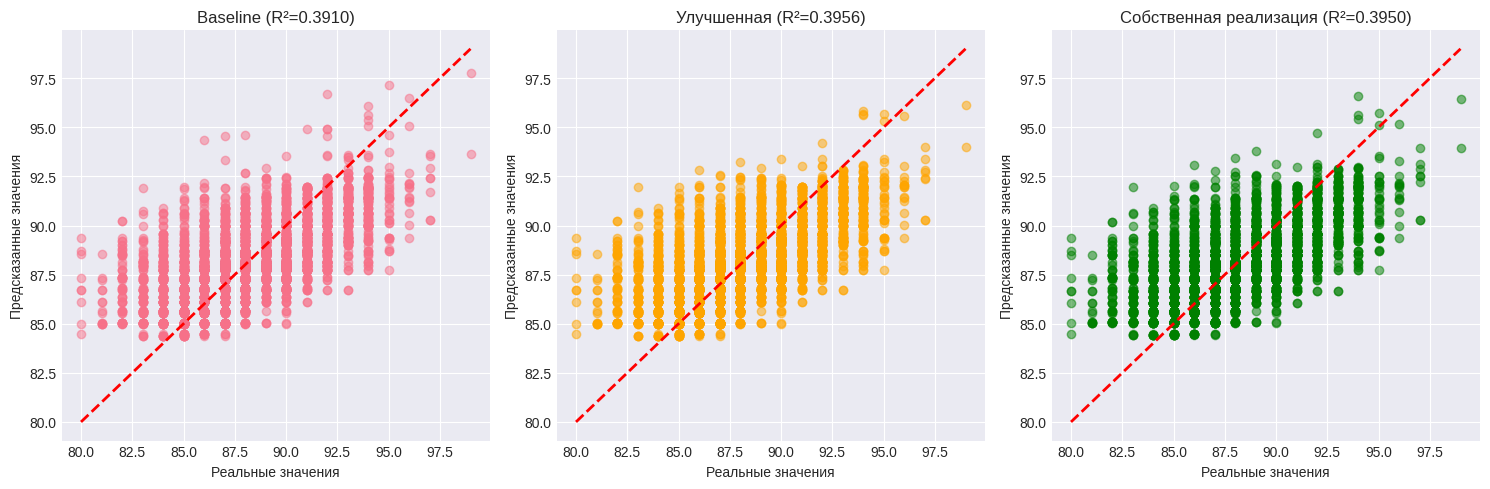

In [14]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_test_wines, y_pred_reg_baseline, alpha=0.5)
plt.plot([y_test_wines.min(), y_test_wines.max()], [y_test_wines.min(), y_test_wines.max()], 'r--', lw=2)
plt.xlabel('Реальные значения')
plt.ylabel('Предсказанные значения')
plt.title(f'Baseline (R²={r2_baseline:.4f})')

plt.subplot(1, 3, 2)
plt.scatter(y_test_wines, y_pred_reg_improved, alpha=0.5, color='orange')
plt.plot([y_test_wines.min(), y_test_wines.max()], [y_test_wines.min(), y_test_wines.max()], 'r--', lw=2)
plt.xlabel('Реальные значения')
plt.ylabel('Предсказанные значения')
plt.title(f'Улучшенная (R²={r2_improved:.4f})')

plt.subplot(1, 3, 3)
plt.scatter(y_test_wines, y_pred_reg_custom, alpha=0.5, color='green')
plt.plot([y_test_wines.min(), y_test_wines.max()], [y_test_wines.min(), y_test_wines.max()], 'r--', lw=2)
plt.xlabel('Реальные значения')
plt.ylabel('Предсказанные значения')
plt.title(f'Собственная реализация (R²={r2_custom:.4f})')

plt.tight_layout()
plt.show()

### Сравнение результатов регрессии

In [15]:
comparison_reg = pd.DataFrame({
    'Модель': ['Baseline', f'Улучшенная (n={n_est_reg})', 'Собственная реализация'],
    'MAE': [mae_baseline, mae_improved, mae_custom],
    'RMSE': [rmse_baseline, rmse_improved, rmse_custom],
    'R²': [r2_baseline, r2_improved, r2_custom]
})
print('\nСравнение моделей регрессии:')
print(comparison_reg.to_string(index=False))


Сравнение моделей регрессии:
                Модель      MAE     RMSE       R²
              Baseline 1.878334 2.395182 0.391030
    Улучшенная (n=100) 1.872416 2.386115 0.395632
Собственная реализация 1.873948 2.387369 0.394997


### Выводы по ЛР№4

1. **Случайный лес** объединяет преимущества нескольких деревьев, снижая переобучение.
2. **Стабильность** - ансамблевый подход делает предсказания более надежными.
3. **Гиперпараметры**: количество деревьев, глубина, min_samples_leaf критичны для настройки.
4. **Важность признаков** - можно извлечь информацию о том, какие признаки наиболее влияют на предсказания.
5. **Собственная реализация** подтверждает основной механизм: Bootstrap Aggregating (Bagging).